# Model Ensembles for Stance Classification 

Our goal is to improve the macro F1-score of our stance classification models by combining multiple models through ensemble techniques. We will explore approaches such as majority voting, soft voting (averaging probabilities), and weighted ensembles.

We will implement:

1. **Soft Voting Ensemble**: average predicted probabilities and select the class with highest average probability.
2. **Hard Voting Ensemble**: majority vote among predicted labels.
3. **Weighted Ensemble**: Assign different weights to each model based on their performance (F1-score) and combine predictions.


The notebook evaluates the performance on a held-out test set and compares ensembles against individual models.
Metrics: accuracy, precision, recall, F1-score (macro), confusion matrix.


In [17]:
#Libraries
import os
import re
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import warnings
warnings.filterwarnings("ignore")

# Google Colab or not
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    path = "/content/drive/MyDrive/multimodal-argmining"
    os.chdir(path)
    print(f"Loading data from Google Drive: {path}")
else:
    path = "/workspace/dzuniga/"
    os.chdir(path)
    print(f"Loading data locally from: {path}")


# GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU ready:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("No GPU detected, using CPU.")

#If we use the augmented dataset:
augmented = True

# Set Seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

Loading data locally from: /workspace/dzuniga/
GPU ready: NVIDIA H100 NVL


In [18]:
# Load Dataset
if augmented:
  train_path = f"{path}/data/train_augmented_synonym.csv"
else:
  train_path = f"{path}/data/train.csv"
dev_path   = f"{path}/data/dev.csv"
test_path  = f"{path}/data/test.csv"

df_train = pd.read_csv(train_path)
df_dev   = pd.read_csv(dev_path)
df_test  = pd.read_csv(test_path)


# Map labels to ints
label2id = {"oppose": 0, "support": 1}


for df in [df_train, df_dev, df_test]:
    df["label"] = df["stance"].map(label2id)


dataset_train = Dataset.from_pandas(df_train[["tweet_text","label"]])
dataset_dev   = Dataset.from_pandas(df_dev[["tweet_text","label"]])
dataset_test  = Dataset.from_pandas(df_test[["tweet_text","label"]])

In [19]:
# Ensemble Model Selection for Stance Detection
ENSEMBLE_MODELS = [
    "roberta-base",                                    # Strong baseline with robust social media understanding
    "microsoft/deberta-v3-base",                       # Advanced attention for nuanced stance reasoning
    "cardiffnlp/twitter-roberta-base-offensive",          # Domain-specific: fine-tuned specifically for stance detection
    "vinai/bertweet-base"                              # Twitter-native: pre-trained on 850M tweets
]

MAX_LENGTH = 105

Short Justification:

1. roberta-base: Provides a solid foundation with extensive pre-training on diverse text, including social media. Handles informal language, typos, and abbreviations well.

2. microsoft/deberta-v3-base: Contributes sophisticated contextual understanding through attention mechanism, crucial for capturing the relationship between 
   arguments and stance targets in controversial topics.

3. cardiffnlp/twitter-roberta-base-stance: Adds task-specific expertise as it's explicitly fine-tuned for stance detection, bringing specialized knowledge to the ensemble.

4. vinai/bertweet-base: Captures Twitter-specific linguistic patterns (hashtags, mentions, emojis, slang) that other models may miss, having been pre-trained exclusively on tweets.

This combination ensures architectural diversity (BERT-based vs RoBERTa-based), capacity variation (general vs specialized), and domain coverage (general NLP vs Twitter-specific).

In [20]:
# We tokenize the dataset for each model in the ensemble
tokenized_datasets = {}
tokenizers = {}

for model_name in ENSEMBLE_MODELS:
    print(f"Tokenizing for {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    tokenizers[model_name] = tokenizer

    def tokenize_batch(batch):
        return tokenizer(batch["tweet_text"],padding="max_length",truncation=True,max_length=MAX_LENGTH)


    tokenized_train = dataset_train.map(tokenize_batch, batched=True)
    tokenized_dev = dataset_dev.map(tokenize_batch, batched=True)
    tokenized_test = dataset_test.map(tokenize_batch, batched=True)

    for ds in [tokenized_train, tokenized_dev, tokenized_test]:
        ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])
    
    tokenized_datasets[model_name] = {
        "train": tokenized_train,
        "dev": tokenized_dev,
        "test": tokenized_test
    }

Tokenizing for roberta-base...


Map:   0%|          | 0/2190 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenizing for microsoft/deberta-v3-base...


Map:   0%|          | 0/2190 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenizing for cardiffnlp/twitter-roberta-base-offensive...


config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Map:   0%|          | 0/2190 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenizing for vinai/bertweet-base...


Map:   0%|          | 0/2190 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [21]:
#Metrics we are going to evaluate
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="binary", pos_label=1)
    precision = precision_score(labels, preds, average="binary", pos_label=1)
    recall = recall_score(labels, preds, average="binary", pos_label=1)
    
    return {"accuracy": acc,"f1": f1,"precision": precision,"recall": recall}


In [22]:
#Fine-tune Each Model
all_model_results = {}

for model_name in ENSEMBLE_MODELS:
    print(f"\nFine-tuning {model_name}...")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
    tokenizer = tokenizers[model_name]
    datasets = tokenized_datasets[model_name]
    
    training_args = TrainingArguments(
        output_dir=f"./temp_models/{model_name}_ensemble",
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="none",
        logging_steps=10
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=datasets["train"],
        eval_dataset=datasets["dev"],
        processing_class=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )
    
    trainer.train()
    
    # Predictions on test set
    predictions_output = trainer.predict(datasets["test"])
    y_pred = np.argmax(predictions_output.predictions, axis=1)
    probs = torch.softmax(torch.tensor(predictions_output.predictions), dim=1).numpy()
    y_true = predictions_output.label_ids

    predictions_output = trainer.predict(datasets["test"])

    # Save metrics
    metrics = compute_metrics(predictions_output)
    all_model_results[model_name] = {
        "metrics": metrics,
        "model_probs":probs,
        "model_preds":y_pred,
        "y_true": y_true
    }
    
    del model, trainer
    torch.cuda.empty_cache()


Fine-tuning roberta-base...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.463200,0.258812,0.890000,0.830769,0.947368,0.739726
2,0.251300,0.258957,0.900000,0.841270,1.000000,0.726027
3,0.164800,0.248245,0.910000,0.875000,0.887324,0.863014
4,0.099400,0.261341,0.915000,0.881119,0.900000,0.863014
5,0.055700,0.315810,0.915000,0.879433,0.911765,0.849315



Fine-tuning microsoft/deberta-v3-base...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.457500,0.286953,0.895000,0.860927,0.833333,0.890411
2,0.212000,0.314624,0.900000,0.846154,0.964912,0.753425
3,0.117200,0.324910,0.920000,0.887324,0.913043,0.863014
4,0.052000,0.466455,0.910000,0.865672,0.950820,0.794521
5,0.024400,0.435196,0.920000,0.884058,0.938462,0.835616



Fine-tuning cardiffnlp/twitter-roberta-base-offensive...


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.413800,0.295794,0.865000,0.825806,0.780488,0.876712
2,0.211500,0.364161,0.885000,0.816000,0.980769,0.698630
3,0.140000,0.397751,0.900000,0.859155,0.884058,0.835616
4,0.084400,0.405354,0.905000,0.865248,0.897059,0.835616
5,0.046000,0.472899,0.900000,0.859155,0.884058,0.835616


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]


Fine-tuning vinai/bertweet-base...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.464600,0.289438,0.880000,0.842105,0.810127,0.876712
2,0.243100,0.295307,0.905000,0.850394,1.000000,0.739726
3,0.147000,0.282229,0.905000,0.874172,0.846154,0.904110
4,0.099800,0.316655,0.910000,0.865672,0.950820,0.794521
5,0.057300,0.293808,0.905000,0.863309,0.909091,0.821918


In [23]:
# We extract predictions and probabilities from each model
model_preds = {name: results["model_preds"] for name, results in all_model_results.items()}
model_probs = {name: results["model_probs"] for name, results in all_model_results.items()}
y_true = list(all_model_results.values())[0]["y_true"] 

### Ensemble Methods

In [24]:
# Hard Voting (Majority)----
all_preds = np.array(list(model_preds.values()))  # dimension [n_models, n_samples]
hard_vote_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=all_preds)

In [25]:
# Soft Voting (Average Probabilities) ---
all_probs = np.array(list(model_probs.values()))  # dimension [n_models, n_samples, n_classes]
soft_vote_preds = np.argmax(np.mean(all_probs, axis=0), axis=1)

In [26]:
# Weighted Ensemble (Based on the F1-Score)----

# We extract F1-scores from each model
f1_scores = np.array([results["metrics"]["f1"] for results in all_model_results.values()])

# Normalize the F1-scores to use them as weights
weights = f1_scores / np.sum(f1_scores)

# Apply weights to the probabilities
weighted_probs = np.tensordot(weights, all_probs, axes=([0], [0]))  # dimension [n_samples, n_classes]
weighted_vote_preds = np.argmax(weighted_probs, axis=1)


HARD_VOTING Results:
Accuracy: 0.8433
Precision: 0.8391
Recall: 0.8545
F1-Score: 0.8406


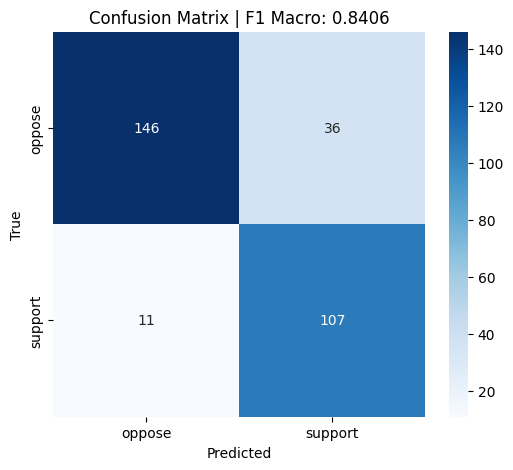


SOFT_VOTING Results:
Accuracy: 0.8367
Precision: 0.8347
Recall: 0.8505
F1-Score: 0.8344


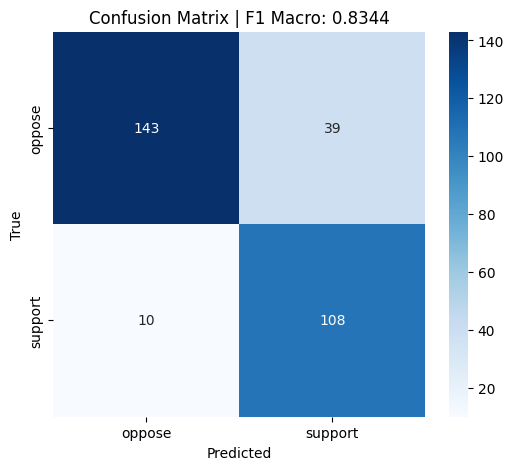


WEIGHTED_VOTING Results:
Accuracy: 0.8400
Precision: 0.8374
Recall: 0.8532
F1-Score: 0.8377


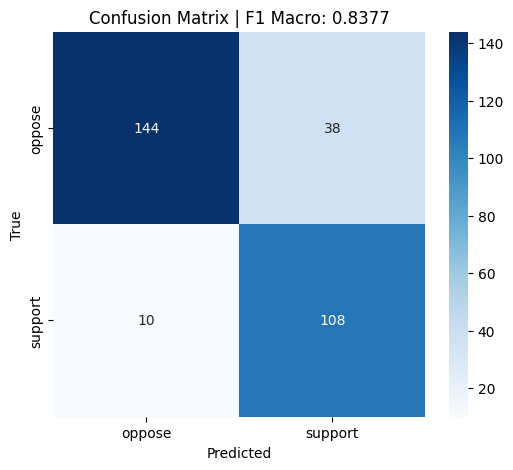


Weights used in Weighted Ensemble:
roberta-base: 0.2573 (F1: 0.8258)
microsoft/deberta-v3-base: 0.2520 (F1: 0.8090)
cardiffnlp/twitter-roberta-base-offensive: 0.2474 (F1: 0.7940)
vinai/bertweet-base: 0.2433 (F1: 0.7810)


In [27]:
# Evaluate Ensembles and Display Results
ensemble_results = {}

for ensemble_name, y_pred in [("hard_voting", hard_vote_preds), ("soft_voting", soft_vote_preds),("weighted_voting", weighted_vote_preds)]:
    
    #Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro")
    rec = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred)


    ensemble_results[ensemble_name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "predictions": y_pred
    }
    
    print(f"\n{ensemble_name.upper()} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

    plt.figure(figsize=(6,5))
    labels=["oppose","support"]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix | F1 Macro: {f1:.4f}")
    plt.show()

# Show the weights used in weighted ensemble
print("\nWeights used in Weighted Ensemble:")
for model_name, weight, f1 in zip(all_model_results.keys(), weights, f1_scores):
    print(f"{model_name}: {weight:.4f} (F1: {f1:.4f})")

In [28]:
# Save Results
ensemble_data = []
for ensemble_name, metrics in ensemble_results.items():
    ensemble_data.append({
        "ensemble_method": ensemble_name,
        "accuracy": metrics["accuracy"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1": metrics["f1"]
    })

results_df = pd.DataFrame(ensemble_data)
results_df = results_df.sort_values(by="f1", ascending=False).reset_index(drop=True)

# Guardar como CSV
results_df.to_csv(f"{path}/experiments/text/Ensemble/ensemble_results.csv", index=False)
print(f"Ensemble results saved to {path}/experiments/text/Ensemble/ensemble_results.csv")

Ensemble results saved to /workspace/dzuniga//experiments/text/Ensemble/ensemble_results.csv
